# REGRESSION MODELS

## Objectives

*   Create a univariate base model to compare regression model results.
*   Create predictor and target values for univariate model.
*   Apply different regression models and determine which fits the best.
*   Create a multivariate base model to compare regression model results.
*   Create predictor and target values for multivariate model.
*   Apply different regression models and determine which fits the best.


# IMPORT DATA

In [149]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style('darkgrid') 
font = {'weight' : 'bold', 'size' : 23}
matplotlib.rc('font', **font)
plt.style.use('seaborn')

pd.set_option('display.max_columns',0)


from sklearn import metrics

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import RidgeCV, LassoCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


import warnings
warnings.filterwarnings('ignore')


In [150]:
df = pd.read_csv('/content/thermostat_single_building_data.csv').drop(['Unnamed: 0', 'temp_diff'], axis=1)
df.head()

,ts,outdoor_temp,boiler_on,indoor_temp
0,2020-11-17 20:24:00,51.998,1.0,73.7375
1,2020-11-17 20:25:00,51.895,1.0,73.7375
2,2020-11-17 20:26:00,51.792,1.0,73.7375
3,2020-11-17 20:27:00,51.331,1.0,73.7375
4,2020-11-17 20:28:00,51.343,1.0,73.7375


Convert dataset to time series.

In [151]:
df['ts'] = pd.to_datetime(df['ts'])
ts = df.set_index('ts')
ts.index = pd.to_datetime(ts.index, unit='s')
ts.head()

,outdoor_temp,boiler_on,indoor_temp
ts,,,
2020-11-17 20:24:00,51.998,1.0,73.7375
2020-11-17 20:25:00,51.895,1.0,73.7375
2020-11-17 20:26:00,51.792,1.0,73.7375
2020-11-17 20:27:00,51.331,1.0,73.7375
2020-11-17 20:28:00,51.343,1.0,73.7375


# UNIVARIATE BASE MODEL

For base model, we analyze how the indoor temperature is changing after 5 minutes. Our assumption is after 5 minutes, the indoor temperature will be the same. We create a new column with the next 5th minute's temperature by shifting data with periods of 5.

In [152]:
# Create a time series with indoor_temp column
ts_temp = ts.drop(['outdoor_temp', 'boiler_on'], axis=1)
ts_temp.tail(15)

,indoor_temp
ts,
2020-12-17 20:07:00,72.2745
2020-12-17 20:08:00,72.2185
2020-12-17 20:09:00,72.3310
2020-12-17 20:10:00,72.3310
2020-12-17 20:11:00,72.3310
2020-12-17 20:12:00,72.2745
2020-12-17 20:13:00,72.2745
2020-12-17 20:14:00,72.3870
2020-12-17 20:15:00,72.3870


In [153]:
ts_shift = ts_temp.shift(periods=-5)
ts_shift = ts_shift.rename(columns={'indoor_temp':'shift_temp'})
ts_shift.tail(15)

,shift_temp
ts,
2020-12-17 20:07:00,72.2745
2020-12-17 20:08:00,72.2745
2020-12-17 20:09:00,72.3870
2020-12-17 20:10:00,72.3870
2020-12-17 20:11:00,72.3870
2020-12-17 20:12:00,72.3310
2020-12-17 20:13:00,72.3310
2020-12-17 20:14:00,72.3310
2020-12-17 20:15:00,72.3310


In [154]:
ts_base = pd.concat([ts_temp, ts_shift], axis=1)
ts_base.dropna(inplace=True)
ts_base.tail()

,indoor_temp,shift_temp
ts,,
2020-12-17 20:12:00,72.2745,72.331
2020-12-17 20:13:00,72.2745,72.331
2020-12-17 20:14:00,72.3870,72.331
2020-12-17 20:15:00,72.3870,72.331
2020-12-17 20:16:00,72.3870,72.331


In [155]:
# Use mean squard error to calculate error.
mse = mean_squared_error(ts_base['indoor_temp'], ts_base['shift_temp'])
print('Mean Squared Error of Base Model:', round(mse,5))

Mean Squared Error of Base Model: 0.06772


# UNIVARIATE REGRESSION MODELS

## Data Prepocessing

In [158]:
ts_reg = ts_temp.copy()
ts_reg.head()

,indoor_temp
ts,
2020-11-17 20:24:00,73.7375
2020-11-17 20:25:00,73.7375
2020-11-17 20:26:00,73.7375
2020-11-17 20:27:00,73.7375
2020-11-17 20:28:00,73.7375


### Creating Predictors

Create a data frame by shifting the data 5 times. This way, we store the indoor temperature at a certain time and previous 4 datapoints.

In [159]:
for i in range(1,5):
  ts_reg['in_temp'+str(i)+'_min_ago'] = ts_reg['indoor_temp'].shift(i)

ts_reg.dropna(inplace=True)
ts_reg.head(10)

,indoor_temp,in_temp1_min_ago,in_temp2_min_ago,in_temp3_min_ago,in_temp4_min_ago
ts,,,,,
2020-11-17 20:28:00,73.7375,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:29:00,73.7375,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:30:00,73.7375,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:31:00,73.7375,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:32:00,73.7375,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:33:00,73.5685,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:34:00,73.5685,73.5685,73.7375,73.7375,73.7375
2020-11-17 20:35:00,73.5685,73.5685,73.5685,73.7375,73.7375
2020-11-17 20:36:00,73.5685,73.5685,73.5685,73.5685,73.7375


### Creating Target

In [160]:
# Create target column with the next 5th minute's values using 'shift'.
target = ts_reg[['indoor_temp']].shift(-5)
target.dropna(inplace=True)
target.head()

,indoor_temp
ts,
2020-11-17 20:28:00,73.5685
2020-11-17 20:29:00,73.5685
2020-11-17 20:30:00,73.5685
2020-11-17 20:31:00,73.5685
2020-11-17 20:32:00,73.5685


In [161]:
print(len(ts_reg), len(target))
ts_reg = ts_reg[:len(target)]
print(len(ts_reg), len(target))

41894 41889
41889 41889


### Train-Test Split

In [162]:
# Apply random train test split.
X_train, X_test, y_train, y_test = train_test_split(ts_reg, target, test_size=0.25, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31416, 5) (10473, 5) (31416, 1) (10473, 1)


In [163]:
## We can also apply data split. This cause seasonality. 
## Splitted train test sets provide worse results.

# train_size = 0.75
# split_idx = round(len(ts_reg)* train_size)
# split_idx
# # Split predictors
# X_train = ts_reg.iloc[:split_idx]
# X_test = ts_reg.iloc[split_idx:]
# # Split target
# y_train = target.iloc[:split_idx]
# y_test = target.iloc[split_idx:]

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [164]:
# Scaled train and test datasets.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(y_train)
X_test_scaled = scaler.transform(X_test)
y_test_scaled = scaler.transform(y_test)

### Functions

In [165]:
def plot_feature_importances(model, X):
    
    """
    Function to plot regression model's feature importances.
    This model must be fitted to the X and y.

    ----------
    
    Args:
        model: The regression model fitted to the data.
        X: Model predictors.
    
    Returns:
        A vertical bar plot with the predictors in the model
        and their feature importance value calculated by
        ensemble methods .feature_importance method.
    
    """
    
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values, fontsize=13) 
    plt.xlabel('Feature importance', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    plt.title('Feature Importance Plot', fontsize=20)


In [166]:
def plot_feature_importances_scaled(model, X, X_scaled):

    """
    Function to plot regression model's feature importances.
    This model must be fitted to the X_scaled and y_scaled.

    ----------
    
    Args:
        model: The regression model fitted to the data.
        X: Model predictors.
        X_scaled: Scaled training predictors.
    
    Returns:
        A vertical bar plot with the scaled predictors in the model
        and their feature importance value calculated by
        ensemble methods .feature_importance method.
    
    """

    n_features = X_scaled.shape[1]
    sns.set_style('darkgrid')
    plt.figure(figsize=(8, 8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values, fontsize=13) 
    plt.xlabel('Feature Importance', fontsize=16)
    plt.ylabel('Features', fontsize=16)
    plt.title('Feature Importance Plot', fontsize=20)


In [186]:
def feature_importance_df(model, X):
    """
    Function to create a pandas feature importance dataframe and plot a bar graph.

    -----------

    Args:
      model: Pipeline model name.
      X: Predictor dataframe. It is used for predictor column names in the model.
    Returns:
      Descending feature importance dataframe as features are indices.
      Feature importances bar plot.

    """
    coefs = pd.DataFrame(
               model.named_steps['m'].feature_importances_,
               columns=['Feature_Importances'], index=X.columns
               )
    coefs['Feature_Importances'] = round(coefs['Feature_Importances'],5)
    coefs = coefs.sort_values(by='Feature_Importances', ascending=False)

    fig = plt.figure(figsize=(18,8))
    ax1 = fig.add_subplot(121)
    ax1.barh(y=coefs.index, width=coefs['Feature_Importances'])
    ax1.set_title('Feature Importances', fontsize=14)

    ax2 = fig.add_subplot(122)
    font_size=12
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = coefs.values, rowLabels = coefs.index, bbox=bbox, colLabels=coefs.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    plt.tight_layout()

In [187]:
def regression_modeling(regressor, scaler, name):

    """
    Function to apply a regression model with a pipeline.
     
      - Pipeline is created with the regressor and scaler.
      - Pipeline is fit to X_train and y_train.
      - Prediction is created for X_test.

    ----------

    Args:
      regressor : Initiated regression method.
      scaler    : Initiated standardization method.
      name      : Name of the regression model.

    Returns:
      - Print train and test scores.
      - Print mean squared error value.
      - Returns feature_importance_df function refults.
          * A feature importance dataframe and a bar plot.    
    """

    pipeline = Pipeline([('ss', scaler),
                         ('m', regressor)])
    
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    print('Train Score : ', round(pipeline.score(X_train, y_train),5))
    print('Test Score  : ', round(pipeline.score(X_test, y_test),5), '\n')

    mse = round(mean_squared_error(y_test, y_pred),5)
    print(name+' Mean Squared Error : ', mse)
    print('\n\n')

    feature_importance_df(pipeline, X_train)

## LassoCV

In [169]:
lasso = LassoCV(cv=5, random_state=123)
scaler = StandardScaler()

pipeline_lasso = Pipeline([('ss', scaler),
                           ('m', lasso)])

pipeline_lasso.fit(X_train, y_train)

y_lasso = pipeline_lasso.predict(X_test)

print('Train Score : ', round(pipeline_lasso.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_lasso.score(X_test, y_test),5))


mse_lasso = round(mean_squared_error(y_test, y_lasso),5)
print('LassoCV Mean Squared Error : ', mse_lasso)

Train Score :  0.97393
Test Score  :  0.97222
LassoCV Mean Squared Error :  0.06938


## LassoLarsCV

In [170]:
lassolarscv = LassoLarsCV(cv=5)
scaler = StandardScaler()

pipeline_lassolars = Pipeline([('ss', scaler),
                               ('m', lassolarscv)])

pipeline_lassolars.fit(X_train, y_train)

y_lassolars = pipeline_lassolars.predict(X_test)

print('Train Score : ', round(pipeline_lassolars.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_lassolars.score(X_test, y_test),5))

mse_lassolars = round(mean_squared_error(y_test, y_lassolars),5)
print('LassoLarsCV Mean Squared Error : ', mse_lassolars)

Train Score :  0.97393
Test Score  :  0.97223
LassoLarsCV Mean Squared Error :  0.06938


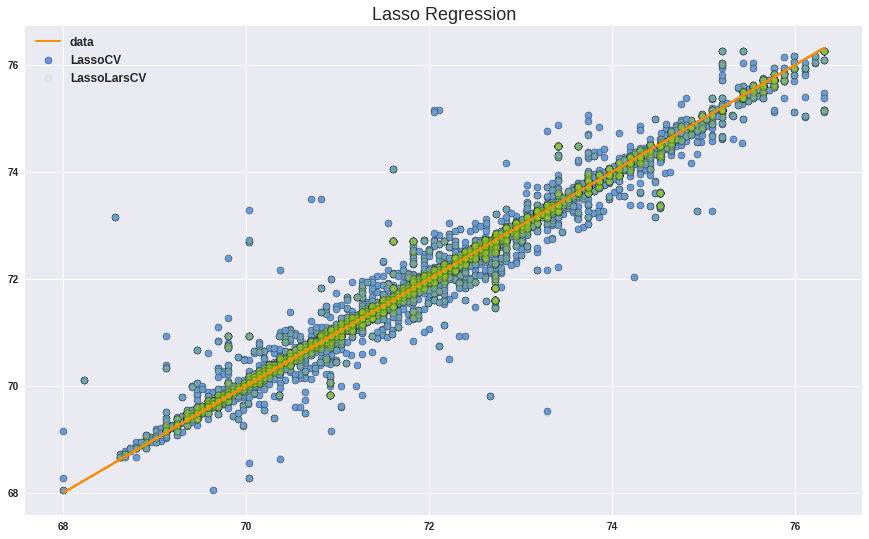

In [171]:
plt.figure(figsize=(15,9))

plt.plot(y_test, y_test, color='darkorange', label='data', linewidth=2)


plt.scatter(y_test, y_lasso, 
            color='cornflowerblue', edgecolor='black',
            label='LassoCV')

plt.scatter(y_test, y_lassolars, 
            color='yellowgreen', edgecolor='black',
            label='LassoLarsCV', alpha=0.1)

plt.title('Lasso Regression', fontsize=18)
plt.legend(fontsize=12)
plt.show()

### ***Observation***

We observe LassoCV and LassoLarsCV models provide same train, test and mean squared error results. When we visulize the predictions of these two regression models, LassoLarsCV model's predictions are clustered around the test daha versus LassoCV predictions are more versatile.

### GridSearchCV

In [172]:
lassolarscv = LassoLarsCV()
scaler = StandardScaler()

lasso_params = {'fit_intercept': [True, False],
                'max_iter': [100, 500, 1000],
                'cv': [3, 5, 7],
                'max_n_alphas': [100, 500, 1000]}

lasso_gridsearch = GridSearchCV(estimator=lassolarscv,
                                param_grid=lasso_params,
                                cv=5,
                                return_train_score=True)


pipeline_gs =  Pipeline([('ss', scaler),
                         ('m', lasso_gridsearch)])


pipeline_gs.fit(X_train, y_train)

y_gs = pipeline_gs.predict(X_test)

print('Train Score : ', round(pipeline_gs.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_gs.score(X_test, y_test),5),'\n')

mse_gs = round(mean_squared_error(y_test, y_gs),5)
print('LassoLarsCV GridSearch Mean Squared Error : ', mse_gs)

Train Score :  0.97393
Test Score  :  0.97223 

LassoLarsCV GridSearch Mean Squared Error :  0.06938


In [173]:
print('Best Parameters For GridSearch:')
print(lasso_gridsearch.best_params_, '\n')

Best Parameters For GridSearch:
{'cv': 5, 'fit_intercept': True, 'max_iter': 100, 'max_n_alphas': 100} 



## Decision Tree Regression

Apply Decision Tree Regressor with different maximum depth and observe the predictions.

In [181]:
dtr_1 = DecisionTreeRegressor(criterion='mse', 
                              max_depth=2,
                              random_state=12)

scaler = StandardScaler()

# regression_modeling(dtr_1, scaler, 'Decision Tree Regression - Max Depth=2 : ')

decision_tree_1 = dtr_1.fit(X_train, y_train)
pred_1 = decision_tree_1.predict(X_test)

print('Train Score : ', round(decision_tree_1.score(X_train, y_train),5))
print('Test Score  : ', round(decision_tree_1.score(X_test, y_test),5))

mse_1 = round(mean_squared_error(y_test, pred_1),5)
print('Mean Squared Error of Decison Tree Regressor: ', mse_1)

Train Score :  0.88438
Test Score  :  0.88509
Mean Squared Error of Decison Tree Regressor:  0.28703


In [180]:
dtr_2 = DecisionTreeRegressor(criterion='mse', 
                              max_depth=5,
                              random_state=12)

scaler = StandardScaler()

# regression_modeling(dtr_1, scaler, 'Decision Tree Regression - Max Depth=5 : ')


decision_tree_2 = dtr_2.fit(X_train, y_train)
pred_2 = decision_tree_2.predict(X_test)

print('Train Score : ', round(decision_tree_2.score(X_train, y_train),5))
print('Test Score  : ', round(decision_tree_2.score(X_test, y_test),5))

mse_2 = round(mean_squared_error(y_test, pred_2),5)
print('Mean Squared Error of Decison Tree Regressor: ', mse_2)

Train Score :  0.97565
Test Score  :  0.97318
Mean Squared Error of Decison Tree Regressor:  0.06698


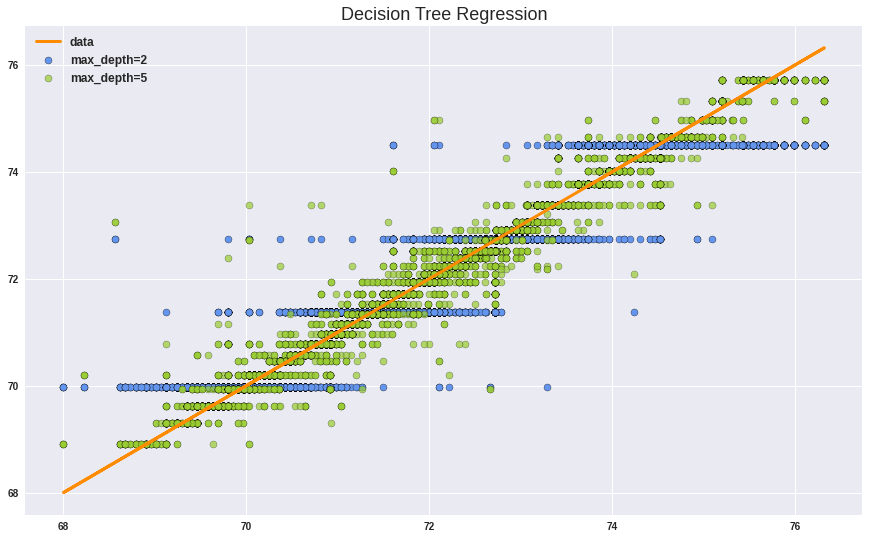

In [177]:
plt.figure(figsize=(15,9))

plt.plot(y_test, y_test, color='darkorange', label='data', linewidth=3)


plt.scatter(y_test, pred_1, 
            color='cornflowerblue', edgecolor='black',
            label='max_depth=2')

plt.scatter(y_test, pred_2, 
            color='yellowgreen', edgecolor='black',
            label='max_depth=5', alpha=0.7)

plt.title('Decision Tree Regression', fontsize=18)
plt.legend(fontsize=12)
plt.show()

Train Score :  0.98434
Test Score  :  0.97492 

Decision Tree Regression Mean Squared Error :  0.06263





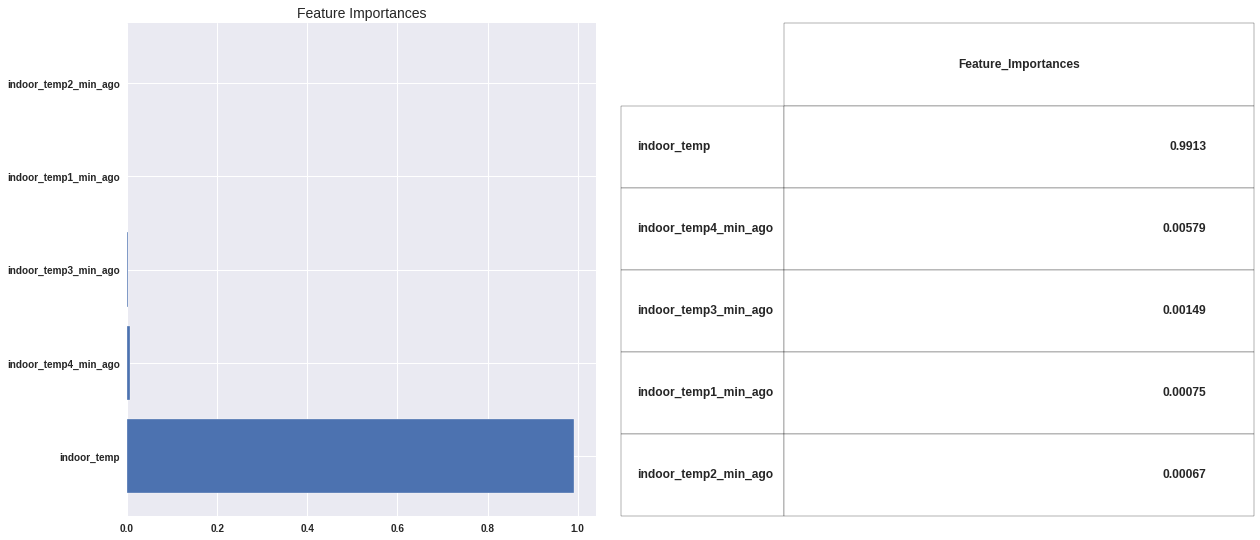

In [129]:
dtr_reg = DecisionTreeRegressor(criterion='mse',
                                random_state=123)
scaler = StandardScaler()

regression_modeling(dtr_reg, scaler, 'Decision Tree Regression')

### ***Observation***

*   We apply Decision Tree Regressor with max_depth values 2 and 5. We observe that max_depth 5 has a better train and test score and highly improved MSE value.

*   We applied GridSearch Method and it did not improve model's residuls. We set the parameters to criterion as 'mse' and fit the model.

*   Decision Tree Regression MSE is 0.063.

*   This model is heavily relies on the last indoor_temperature measured.

## Random Forest Regressor

Train Score :  0.98383
Test Score  :  0.97683 

Random Forest Regression Mean Squared Error :  0.05787





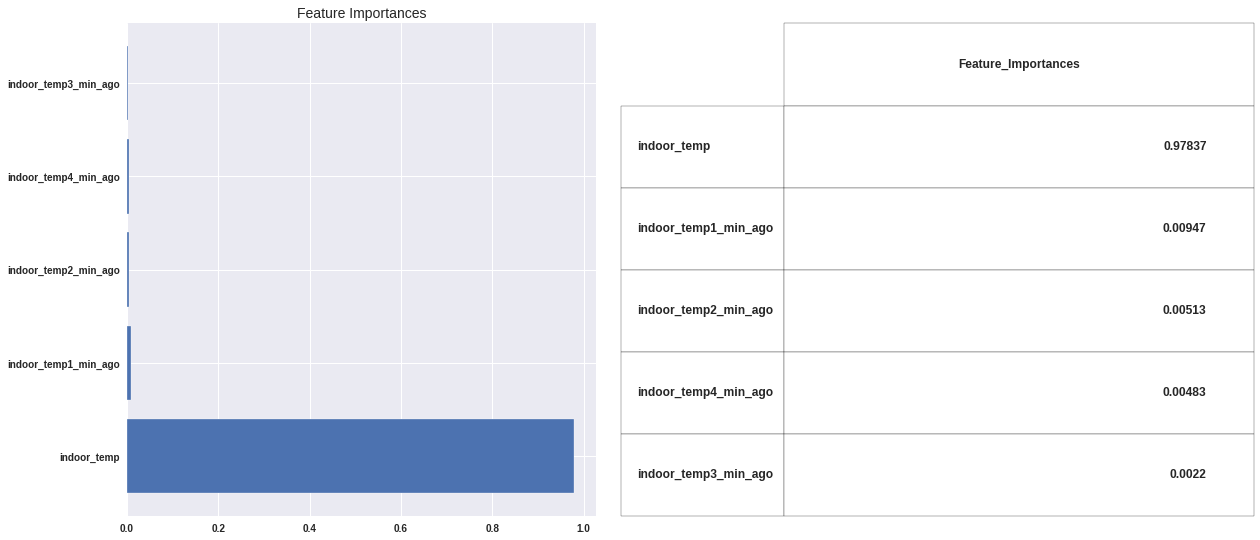

In [130]:
rf_reg = RandomForestRegressor(criterion='mse', 
                               random_state=123)
scaler = StandardScaler()

regression_modeling(rf_reg, scaler, 'Random Forest Regression')

### ***Observation***

*   We applied GridSearch Method and it did not improve model's residuls. 

*   We set the model parameters to criterion as 'mse' and fit the model.

*   Random Forest Regression MSE is 0.058.

*   This model is heavily relies on the last indoor_temperature measured. We observe a slight imporovement on other predictors' feature importance.

## Gradient Boosting Regressor


Train Score :  0.97861
Test Score  :  0.97549 

Gradient Boosting Regression Mean Squared Error :  0.06121





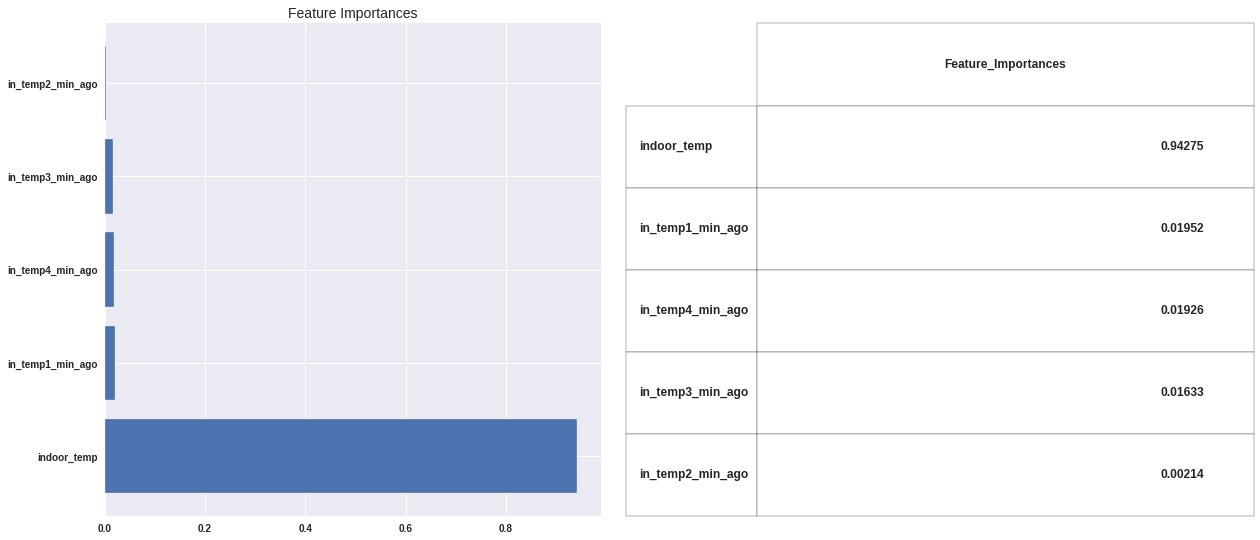

In [189]:
gb_reg = GradientBoostingRegressor(criterion='mse',
                                   random_state=123)
scaler = StandardScaler()

regression_modeling(gb_reg, scaler, 'Gradient Boosting Regression')

### GridSearchCV

In [190]:
gb_reg = GradientBoostingRegressor()
scaler = StandardScaler()

gb_params = {'criterion': ['mse'],
             'max_depth': [5,8,11],
             'min_samples_split': [2,3,5],
             'min_samples_leaf': [1,3,5],
             'random_state': [123]}

gb_gridsearch = GridSearchCV(estimator=gb_reg,
                             param_grid=gb_params,
                             cv=5,
                             return_train_score=True)

pipeline_gs = Pipeline([('ss', scaler),
                        ('m', gb_gridsearch)])

pipeline_gs.fit(X_train, y_train)

y_gs = pipeline_gs.predict(X_test)

print('Train Score : ', round(pipeline_gs.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_gs.score(X_test, y_test),5), '\n')

mse_gs = round(mean_squared_error(y_test, y_gs),5)
print('Gradient Boosting Regressor GridSearch Mean Squared Error : ', mse_gs)

Train Score :  0.9835
Test Score  :  0.97774 

Gradient Boosting Regressor GridSearch Mean Squared Error :  0.06121


In [192]:
print('Best Parameters for Gradient Boosting Regressor Model:')
gb_gridsearch.best_params_

Best Parameters for Gradient Boosting Regressor Model:


{'criterion': 'mse',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 123}

### ***Observation***

*   We apply Gradient Booting Regressor with criterion and random_state parameters. The model's MSE is 0.061.

*   We apply GridSearch Method and it improves model's MSE. 

*   Best parameters are:

      * criterion: 'mse'
      * max_depth: 8
      * min_samples_leaf: 1
      * min_samples_split: 2
      * random_state: 123

*   Gradient Boosting Regression GridSearch MSE is 0.056.



## Stacking Regressor

In [135]:
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=123)),
              ('knr', KNeighborsRegressor(n_neighbors=20,
                                          metric='euclidean'))]


final_estimator = GradientBoostingRegressor(criterion='mse',
                                            random_state=123)

stacking_reg = StackingRegressor(
                                  estimators=estimators,
                                  final_estimator=final_estimator,
                                  cv=5) 

pipeline_stack = Pipeline([('ss', scaler),
                           ('m', stacking_reg)])

pipeline_stack.fit(X_train,y_train) 

y_stack = pipeline_stack.predict(X_test)

print('Train Score : ', round(pipeline_stack.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_stack.score(X_test, y_test),5), '\n')

mse_stack = round(mean_squared_error(y_test, y_stack),5)
print('Stacking Regression Mean Squared Error : ', mse_stack)

Train Score :  0.97746
Test Score  :  0.97476 

Stacking Regression Mean Squared Error :  0.06304


### ***Observation***

*   We apply Stacking Regressor with RidgeCV, LassoCV, and KNeighbors Regressors.

*   This model's MSE is 0.063.

## Adaboost Regressor

Train Score :  0.93281
Test Score  :  0.93148 

AdaBoost Regression Mean Squared Error :  0.17114





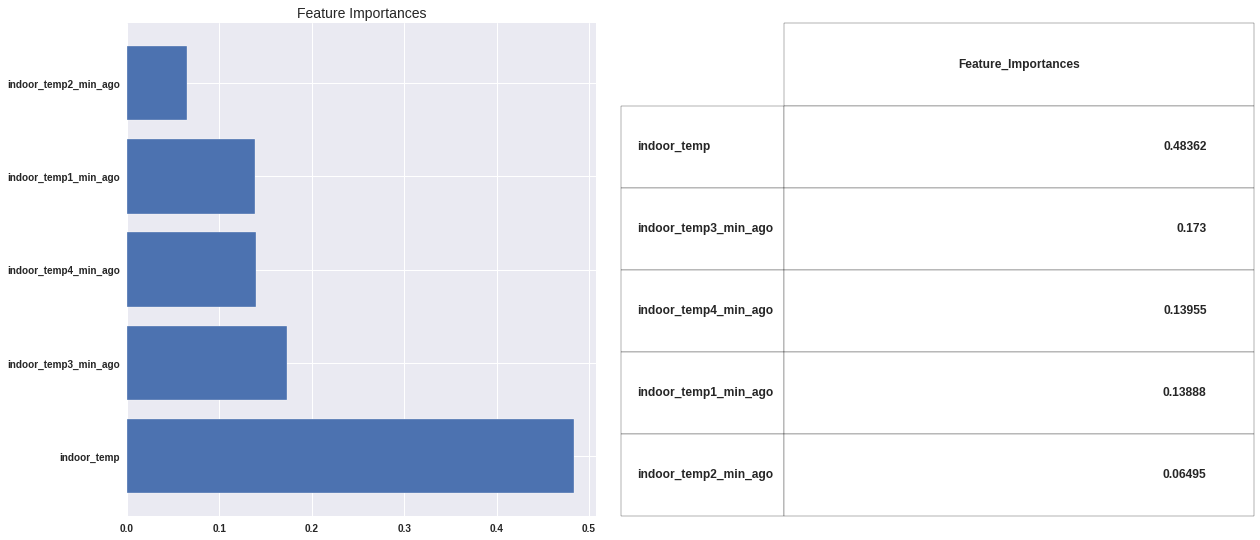

In [145]:
ab_reg = AdaBoostRegressor(random_state=123)
scaler = StandardScaler()

regression_modeling(ab_reg, scaler, 'AdaBoost Regression')

## Bagging Regressor

### DecisionTreeRegressor Bagging

In [ ]:
dt_bagging = BaggingRegressor(DecisionTreeRegressor(criterion='mse',
                                                    # max_depth=8,
                                                    # min_samples_leaf=1,
                                                    # min_samples_split=5,
                                                    random_state=123))

scaler = StandardScaler()


pipeline_dt_bag = Pipeline([('ss', scaler),
                            ('m', dt_bagging)])

pipeline_dt_bag.fit(X_train, y_train)

y_dt_bag = pipeline_dt_bag.predict(X_test)

print('Train Score : ', round(pipeline_dt_bag.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_dt_bag.score(X_test, y_test),5), '\n')

mse_dt_bag = round(mean_squared_error(y_test, y_dt_bag),5)
print('Decision Tree Regression with Bagging Mean Squared Error : ', mse_dt_bag)

Train Score :  0.98353
Test Score  :  0.97664 

Mean Squared Error of Decision Tree Regressor with Bagging:  0.05834


### RandomForestRegressor Bagging

In [108]:
rf_bagging = BaggingRegressor(RandomForestRegressor(criterion='mse',
                                                    # max_depth=8,
                                                    # min_samples_leaf=1,
                                                    # min_samples_split=3,
                                                    random_state=123))
scaler = StandardScaler()


pipeline_rf_bag = Pipeline([('ss', scaler),
                            ('m', rf_bagging)])

pipeline_rf_bag.fit(X_train, y_train)

y_rf_bag = pipeline_rf_bag.predict(X_test)

print('Train Score : ', round(pipeline_rf_bag.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_rf_bag.score(X_test, y_test),5), '\n')

mse_rf_bag = round(mean_squared_error(y_test, y_rf_bag),5)
print('Random Forest Regressor with Bagging Mean Squared Error : ', mse_rf_bag)

Train Score :  0.98275
Test Score  :  0.97671 

Mean Squared Error of Random Forest Regressor with Bagging:  0.05818


In [197]:
round(0.05818,3)

0.058

### ***Observations***


*   We apply Bagging Regressor with Decision Trees and Random Forest. 

*   The MSE for Decision Tree Regressor with Bagging is 0.05835.

*   The MSE for Random Forest Regressor with Bagging is 0.05818.

*   Bagging Method gives one of the better MSE results.

## Suppor Vector Machines

In [110]:
svr = SVR()
scaler = StandardScaler()  

pipeline_svr = Pipeline([('ss', scaler),
                         ('m', svr)])      


pipeline_svr.fit(X_train, y_train)

y_svr = pipeline_svr.predict(X_test)

print('Train Score : ', round(pipeline_svr.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_svr.score(X_test, y_test),5))
print('\n')

mse_svr = round(mean_squared_error(y_test, y_svr),5)
print('Mean Squared Error of Support Vector Regression: ', mse_svr)

Train Score :  0.9749
Test Score  :  0.97288


Mean Squared Error of Support Vector Regression:  0.06775


## Extra Tree Regressor

Train Score :  0.98434
Test Score  :  0.97424 

Extra Tree Regression Mean Squared Error :  0.06433





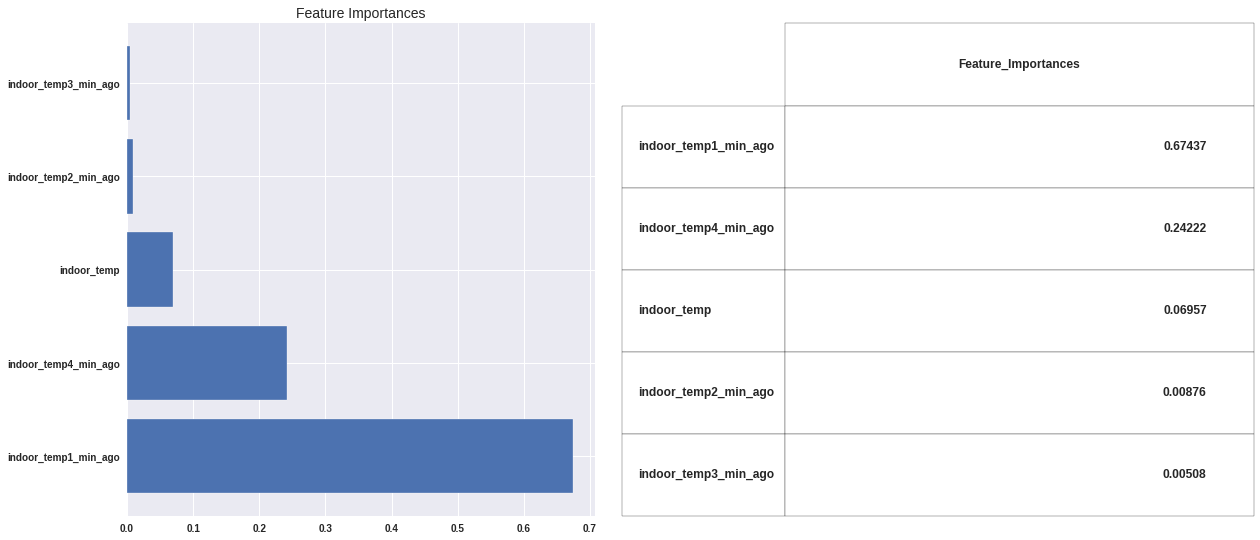

In [111]:
regressor = ExtraTreeRegressor(criterion='mse',
                               random_state=123)
scaler = StandardScaler()

regression_modeling(regressor, scaler, 'Extra Tree Regression')

## Extra Trees Regressor

In [113]:
from sklearn.ensemble import ExtraTreesRegressor

Train Score :  0.98434
Test Score  :  0.97424 

Extra Trees Regression Mean Squared Error :  0.06433





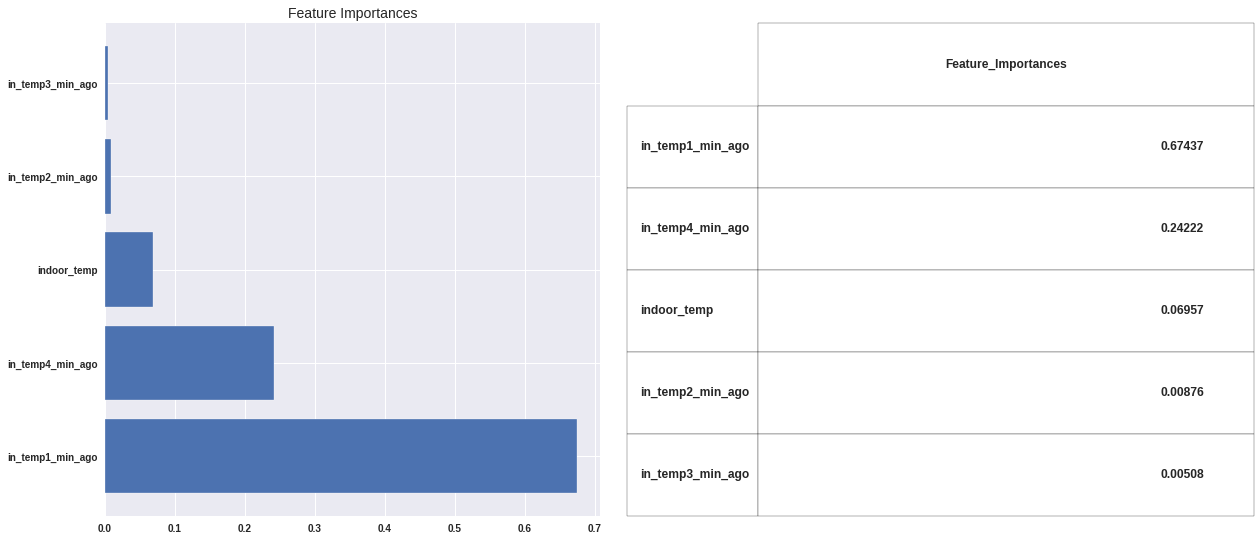

In [198]:
ets_reg = ExtraTreesRegressor(criterion='mse',
                              random_state=123)
scaler = StandardScaler()

regression_modeling(regressor, scaler, 'Extra Trees Regression')


# MULTIVARIATE BASE MODEL

## Data Preprocessing

In [200]:
ts.head()

,outdoor_temp,boiler_on,indoor_temp
ts,,,
2020-11-17 20:24:00,51.998,1.0,73.7375
2020-11-17 20:25:00,51.895,1.0,73.7375
2020-11-17 20:26:00,51.792,1.0,73.7375
2020-11-17 20:27:00,51.331,1.0,73.7375
2020-11-17 20:28:00,51.343,1.0,73.7375


In [204]:
ts_multi = ts.copy()
ts_multi

,outdoor_temp,boiler_on,indoor_temp
ts,,,
2020-11-17 20:24:00,51.998,1.0,73.7375
2020-11-17 20:25:00,51.895,1.0,73.7375
2020-11-17 20:26:00,51.792,1.0,73.7375
2020-11-17 20:27:00,51.331,1.0,73.7375
2020-11-17 20:28:00,51.343,1.0,73.7375
...,...,...,...
2020-12-17 20:17:00,32.421,0.0,72.3310
2020-12-17 20:18:00,32.421,0.0,72.3310
2020-12-17 20:19:00,32.308,0.0,72.3310


### Creating Predictors

By shifting the data set with periods of 5, we store the previous 4 minutes' information at the 5th minute row.

In [205]:
for col in ts_multi.columns:
    for i in range(1,5):
        ts_multi[col+str(i)+'_min_ago'] = ts_multi[col].shift(i)

ts_multi.dropna(inplace=True)
ts_multi.head(10)

,outdoor_temp,boiler_on,indoor_temp,outdoor_temp1_min_ago,outdoor_temp2_min_ago,outdoor_temp3_min_ago,outdoor_temp4_min_ago,boiler_on1_min_ago,boiler_on2_min_ago,boiler_on3_min_ago,boiler_on4_min_ago,indoor_temp1_min_ago,indoor_temp2_min_ago,indoor_temp3_min_ago,indoor_temp4_min_ago
ts,,,,,,,,,,,,,,,
2020-11-17 20:28:00,51.343,1.0,73.7375,51.331,51.792,51.895,51.998,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:29:00,51.100,1.0,73.7375,51.343,51.331,51.792,51.895,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:30:00,50.973,1.0,73.7375,51.100,51.343,51.331,51.792,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:31:00,50.131,1.0,73.7375,50.973,51.100,51.343,51.331,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:32:00,49.825,1.0,73.7375,50.131,50.973,51.100,51.343,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:33:00,50.060,1.0,73.5685,49.825,50.131,50.973,51.100,1.0,1.0,1.0,1.0,73.7375,73.7375,73.7375,73.7375
2020-11-17 20:34:00,49.813,1.0,73.5685,50.060,49.825,50.131,50.973,1.0,1.0,1.0,1.0,73.5685,73.7375,73.7375,73.7375
2020-11-17 20:35:00,50.612,1.0,73.5685,49.813,50.060,49.825,50.131,1.0,1.0,1.0,1.0,73.5685,73.5685,73.7375,73.7375
2020-11-17 20:36:00,50.717,1.0,73.5685,50.612,49.813,50.060,49.825,1.0,1.0,1.0,1.0,73.5685,73.5685,73.5685,73.7375


### Creating Target

In [206]:
#Create target column to compare predictions
target = ts_multi[['indoor_temp']].shift(periods=-5)
target.dropna(inplace=True)
target.head(10)

,indoor_temp
ts,
2020-11-17 20:28:00,73.5685
2020-11-17 20:29:00,73.5685
2020-11-17 20:30:00,73.5685
2020-11-17 20:31:00,73.5685
2020-11-17 20:32:00,73.5685
2020-11-17 20:33:00,73.5685
2020-11-17 20:34:00,73.8495
2020-11-17 20:35:00,73.8495
2020-11-17 20:36:00,73.8495


### Train-Test Split

In [207]:
print(len(ts_multi), len(target))
ts_multi = ts_multi[:len(target)]
print(len(ts_multi), len(target))

41894 41889
41889 41889


In [208]:
X = ts_multi.copy()
y = target.copy()

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31416, 15) (10473, 15) (31416, 1) (10473, 1)


In [210]:
# train_size = 0.75
# split_idx = round(len(ts_reg)* train_size)
# split_idx
# # Split predictors
# X_train = ts_reg.iloc[:split_idx]
# X_test = ts_reg.iloc[split_idx:]
# # Split target
# y_train = target.iloc[:split_idx]
# y_test = target.iloc[split_idx:]

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [211]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(y_train)
X_test_scaled = scaler.transform(X_test)
y_test_scaled = scaler.transform(y_test)

## LassoLarsCV - Base Model

We apply LassoLars CV as our base model to compare Mean Squared Errors of other regression models.

In [212]:
lasso_multi = LassoLarsCV(cv=5)
multi_reg = lasso_multi.fit(X_train, y_train)


selected_features = pd.DataFrame()
selected_features['Feature'] = X_train.columns[lasso_multi.coef_ > 0]
selected_features['Coefficient'] = multi_reg.coef_[lasso_multi.coef_ > 0]
selected_features.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
0,outdoor_temp,0.009165
1,indoor_temp,0.774781
2,boiler_on1_min_ago,0.006232
3,boiler_on2_min_ago,0.003483
4,boiler_on3_min_ago,0.007087
5,boiler_on4_min_ago,0.050022
6,indoor_temp1_min_ago,0.012711
7,indoor_temp3_min_ago,0.027941
8,indoor_temp4_min_ago,0.169791


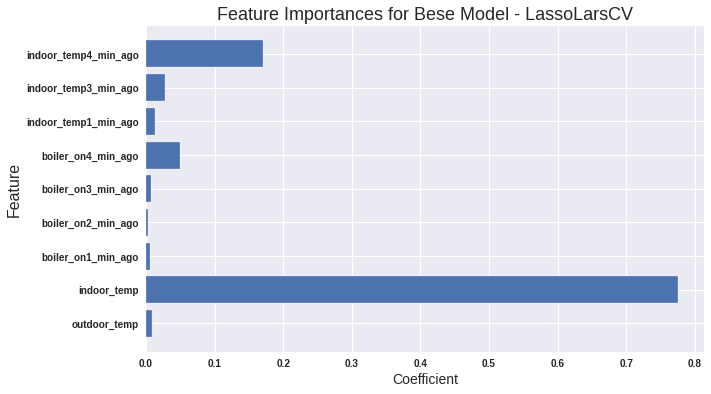

In [216]:
labels = selected_features['Feature']
sizes = selected_features['Coefficient']

plt.figure(figsize=(10,6))
plt.barh(range(len(labels)), sizes, align='center') 
plt.yticks(np.arange(len(labels)), labels) 
plt.title('Feature Importances for Bese Model - LassoLarsCV', fontsize=18)
plt.xlabel('Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=16)
plt.show();

In [217]:
print('Train Score : ', round(multi_reg.score(X_train, y_train),5))
print('Test Score  : ', round(multi_reg.score(X_test, y_test),5))

y_pred_multi = multi_reg.predict(X_test)

mse_multi = round(mean_squared_error(y_test, y_pred_multi),5)
print('Mean Squared Error of Multivatiate LassoLarsCV : ', mse_multi)

Train Score :  0.97423
Test Score  :  0.97255
Mean Squared Error of Multivatiate LassoLarsCV :  0.06855


### ***Observations***


*   We use LassoLarsCV model to create our base model.

*   The MSE of base model is 0.069.

*   Our base model heavily relies on the latest indoor temperature and the first indoor temperature values.

# MULTIVARIATE REGRESSION MODELS

## Gradient Boosting Regressor

Train Score :  0.97958
Test Score  :  0.97698 

Gradient Boosting Regression Mean Squared Error :  0.05751





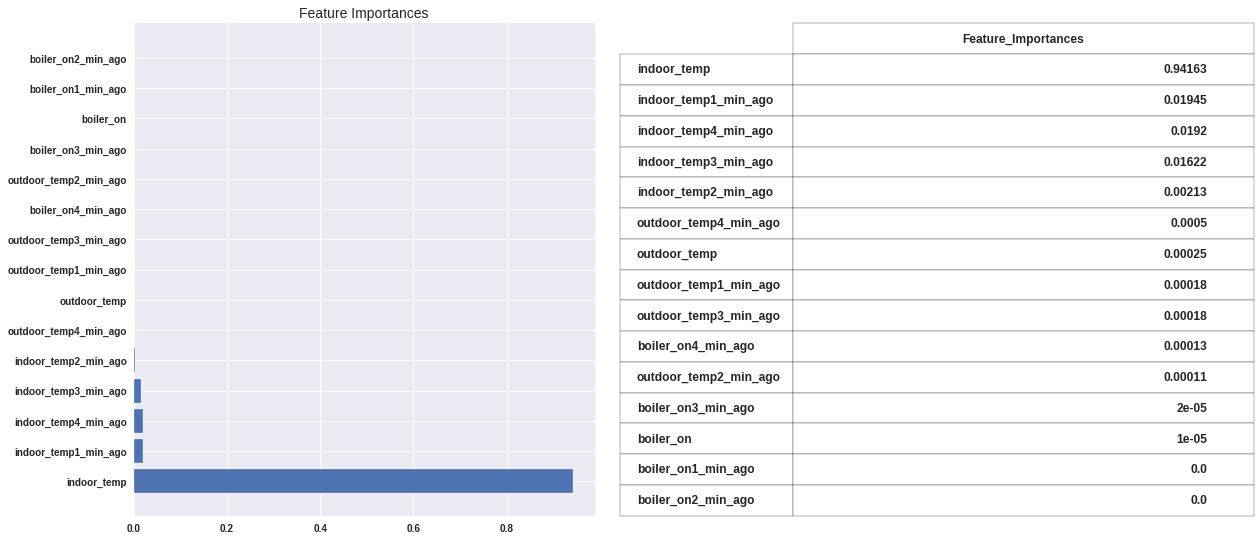

In [218]:
gb_reg = GradientBoostingRegressor(criterion='mse',
                                   random_state=123)
scaler = StandardScaler()

regression_modeling(gb_reg, scaler, 'Gradient Boosting Regression')

### GridSeachCV

In [220]:
gb_reg = GradientBoostingRegressor()
scaler = StandardScaler()

gb_params = {'criterion': ['mse'],
             'max_depth': [3,5,8],
             'min_samples_split': [2,3,5],
             'min_samples_leaf': [1,3,5],
             'random_state': [123]}

gb_gridsearch = GridSearchCV(estimator=gb_reg,
                             param_grid=gb_params,
                             cv=5,
                             return_train_score=True)

pipeline_gb = Pipeline([('ss', scaler),
                        ('m', gb_gridsearch)])

pipeline_gb.fit(X_train, y_train)

y_gb = pipeline_gb.predict(X_test)

print('Train Score : ', round(pipeline_gb.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_gb.score(X_test, y_test),5), '\n')

mse_gb = round(mean_squared_error(y_test, y_gb),5)
print('Mean Squared Error of Gradient Boosting Regressor: ', mse_gb)

Train Score :  0.99211
Test Score  :  0.98278 

Mean Squared Error of Gradient Boosting Regressor:  0.04302


In [221]:
print('Best Parameters for Gradient Boosting Regressor Model:','\n')
gb_gridsearch.best_params_

Best Parameters for Gradient Boosting Regressor Model: 



{'criterion': 'mse',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'random_state': 123}

Train Score :  0.97552
Test Score  :  0.97343 

Best Gradient Boost Regression Mean Squared Error :  0.06636





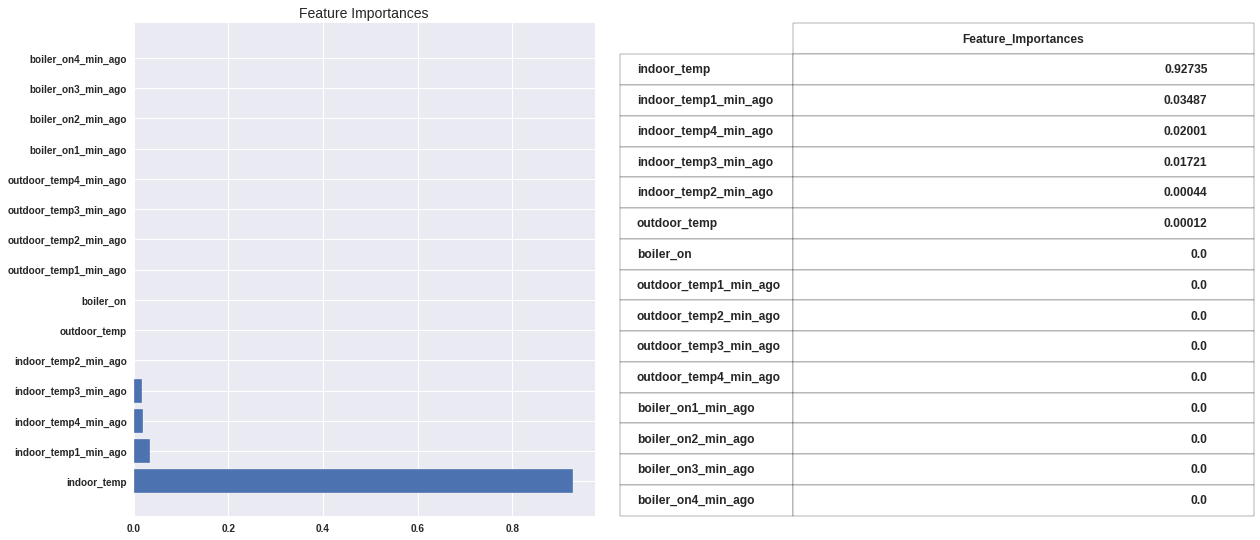

In [222]:
best_gbr = GradientBoostingRegressor(criterion='mse',
                                     max_depth=8 ,
                                     min_samples_split=1.0,
                                     min_samples_leaf=5,
                                     random_state=123)

scaler= StandardScaler()

regression_modeling(best_gbr, scaler, 'Best Gradient Boost Regression' )

### ***Observations***

*   We apply Gradient Boosting Regressor with criterion='mse' and get an MSE of 0.058.

*   Top 5 most important features are indoor temperatures, the latest measurement is the most important of all.

*   We apply GridSearch to improve our model.

*   Best parameters are:

      * criterion: 'mse'
      * max_depth: 8
      * min_samples_leaf: 1
      * min_samples_split: 5
      * random_state: 123

*   GradientSearchCV MSE is 0.043. 

*   We create the model with the best parameters and observe feature importances.

*   This model also heavily relies on indoor temperatures.





## Random Forest Regressor

Train Score :  0.99801
Test Score  :  0.98566 

Random Forest Regression Mean Squared Error :  0.03582





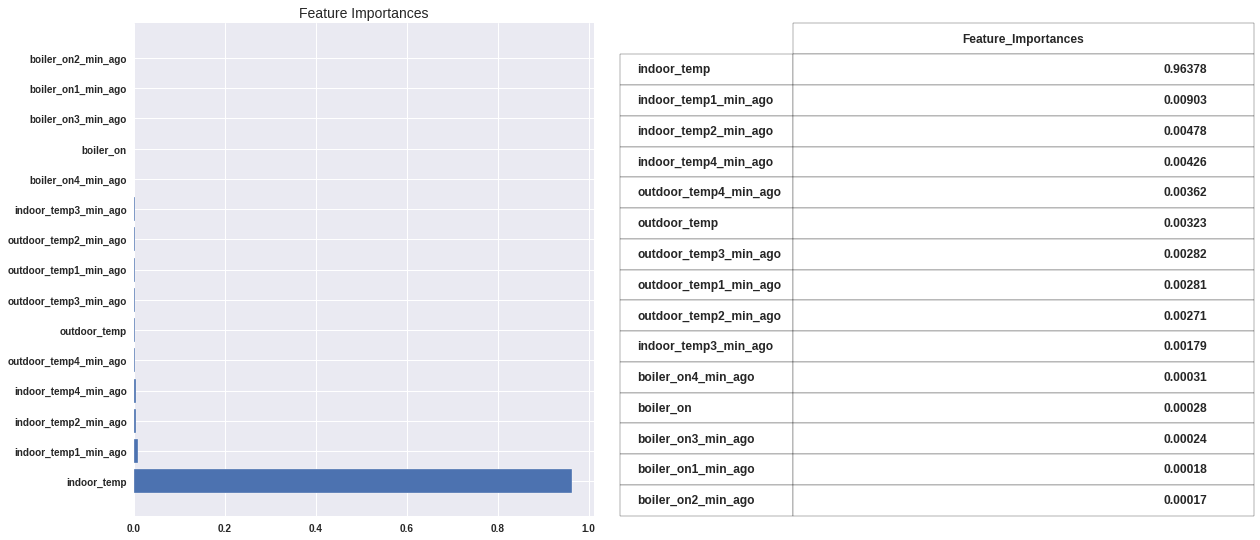

In [223]:
rf_reg = RandomForestRegressor(criterion='mse',
                               random_state=123)
scaler = StandardScaler()

regression_modeling(rf_reg, scaler, 'Random Forest Regression')

### ***Observations***

*   We apply Random Forest Regressor with criterion='mse' parameter.

*   Train and Test Scores are both very close to optimum value.

*   The MSE is 0.036. This is the best Regression model so far.

*   This model heavily rely on the last indoor temperature measurement.



## Bagging Regressor

### DecisionTreeRegressor Bagging

In [226]:
dt_bagging = BaggingRegressor(DecisionTreeRegressor(criterion='mse',
                                                    random_state=123))

scaler = StandardScaler()


pipeline_dt_bag = Pipeline([('ss', scaler),
                            ('m', dt_bagging)])

pipeline_dt_bag.fit(X_train, y_train)

y_dt_bag = pipeline_dt_bag.predict(X_test)

print('Train Score : ', round(pipeline_dt_bag.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_dt_bag.score(X_test, y_test),5), '\n')

mse_dt_bag = round(mean_squared_error(y_test, y_dt_bag),5)
print('Mean Squared Error of Decision Tree Regressor with Bagging: ', mse_dt_bag)

Train Score :  0.9828
Test Score  :  0.97803 

Mean Squared Error of Decision Tree Regressor with Bagging:  0.05488


### RandomForestRegressor Bagging

In [225]:
rf_bagging = BaggingRegressor(RandomForestRegressor(criterion='mse',
                                                    random_state=123))
scaler = StandardScaler()


pipeline_rf_bag = Pipeline([('ss', scaler),
                            ('m', rf_bagging)])

pipeline_rf_bag.fit(X_train, y_train)

y_rf_bag = pipeline_rf_bag.predict(X_test)

print('Train Score : ', round(pipeline_rf_bag.score(X_train, y_train),5))
print('Test Score  : ', round(pipeline_rf_bag.score(X_test, y_test),5), '\n')

mse_rf_bag = round(mean_squared_error(y_test, y_rf_bag),5)
print('Mean Squared Error of AdaBooRandom Forest Regressor with Bagging: ', mse_rf_bag)

Train Score :  0.99438
Test Score  :  0.98408 

Mean Squared Error of AdaBooRandom Forest Regressor with Bagging:  0.03977


### ***Observations***


*   We apply Bagging Regressor with Decision Trees and Random Forest. 

*   The MSE for Decision Tree Regressor with Bagging is 0.038.

*   The MSE for Random Forest Regressor with Bagging is 0.04.

*   Bagging Method gives one of the better MSE results.


## Extra Trees Regressor

Train Score :  1.0
Test Score  :  0.98761 

Extra Trees Regression Mean Squared Error :  0.03094





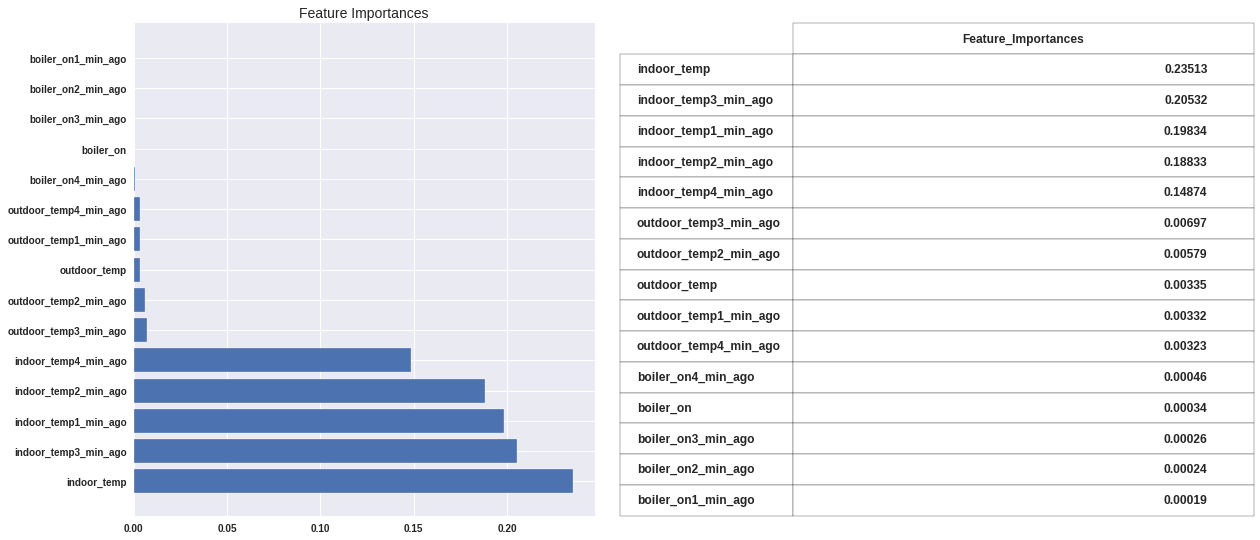

In [227]:
ets_reg = ExtraTreesRegressor(criterion='mse',
                              random_state=123)
scaler = StandardScaler()

regression_modeling(ets_reg, scaler, 'Extra Trees Regression')

### ***Observations***

*   Extra Trees Regression provides the best Mean Squared Error value - 0.031.

*   We observe feature importances is more distributed between indoor temperatures values and not heavily rely on the lates temperature.

*   We also observe outdoor temperature also have higher importance.


# SUMMARY

*   Multivariate regression models have better results compared to univariate regression models regarding MSE value.

*   Top 3 best models with the least MSE:
      * Extra Trees Regression
      * Random Forest Regression
      * Bagging Regressor

*   We observe that majority of the models are significantly effected by the latest indoor temperature.

*   Extra Trees Regression has higher feature importances for outdoor temperature compared to others.

*   Next, we apply Extra Tree Regression to new data and determine if the model is widely applicable.
